In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
import scipy.stats as stat
import math
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
#actually, work with the .fit file
from astropy.io import fits
dataset = fits.open('dr7qso.fit')
dataset.info()

Filename: dr7qso.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      81   ()      
  1                1 BinTableHDU    156   105783R x 74C   [31A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1D, 1D, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 31A, 31A, 31A]   


In [5]:
#data labels for fits file
#dataset[0].header

In [6]:
#access the data, get relevant flux + redshift data
quas = dataset[1]  #short for quasars
#print(quas.data[123]) #print some line
Z = quas.data['z'] #redshifts
M = quas.data['IMAG'] #"photometric" magnitudes in this band
M

array([20.093, 19.485, 19.148, ..., 19.386, 18.114, 20.437])

In [7]:
#luminosity distance in cm. assume the standard ΛCDM cosmology: H0 = 71 km s−1 Mpc−1, ΩΛ = 0.7, and Ωm = 0.3
#work in cgs
def integrand(x, a, b):
    return 1 / math.sqrt(a + b*(1+x)**3)

def d_lum(z):
    Omega_l = 0.7
    Omega_m = 0.3
    cH0 = 1.32152e+28 #cm, ratio of c to H0
    integral = quad(integrand, 0, z, args = (Omega_l, Omega_m))
    return integral[0] * (1+z) * cH0

In [8]:
#luminosity distance data — probably not necessary
dl = np.array([d_lum(z) for z in Z])
dl

array([4.28466865e+28, 4.32131415e+28, 2.55085379e+28, ...,
       3.90995667e+28, 2.77627069e+28, 2.96689233e+28])

In [9]:
#convert magnitudes to fluxes (in cgs) (multiply Jy by e-23 to get ergs/s/cm^2/Hz)

def magtoflux(m):
    f0 = 3.7e-20
    return f0*10**(-m/2.5)

F = [magtoflux(m) for m in M]
F = np.array(F)

In [10]:
#calculate luminosity, minimum luminosity
def lum(z, f):
    alpha = 0.5 #for optical k-correction
    k = (1+z)**alpha
    return 4*math.pi*(d_lum(z)**2)*f/k

fmin = 0.083e-26 #see Singal et al. (2013)
def lmin(l, f):
    return l*fmin/f

L = [lum(Z[i], F[i]) for i in range(0,len(F))]
L = np.array(L)
Lmin = [lmin(L[i], F[i]) for i in range(0, len(F))]
Lmin = np.array(Lmin)

print(np.argmax(L))
L, Lmin

104775


(array([4.66194982e+30, 8.28305678e+30, 4.47218219e+30, ...,
        7.62396447e+30, 1.34723764e+31, 1.78358364e+30]),
 array([1.13931539e+31, 1.15629063e+31, 4.57715749e+30, ...,
        9.71532273e+30, 5.32010954e+30, 5.98370052e+30]))

# Columns of data:
0 = z

1 = M

2 = F

3 = L

4 = Lmin

In [11]:
#concatenate all data and calcs
data = np.stack((Z, M, F, L, Lmin))
data = np.transpose(data)
df = pd.DataFrame(data, columns= ['z', 'M', 'F', 'L', 'Lmin'])

In [12]:
#truncate data to obtain f_min = 0.083 mJy, aka m_max = 19.1
data_temp = [];
data_trunc = [];
m_max = 19.1 
m_min = 15
for i in range(0, len(data[:,1])):
    if(data[i,1] >= m_min):
        if(data[i,1] <= m_max):
            data_temp.append(data[i,:])
        else:
            data_trunc.append(data[i,:])

data_trunc = np.array(data_trunc)        
data = np.array(data_temp)
print data[:,1], data.shape, np.amax(data[:,0])

[18.301 18.775 17.934 ... 18.525 18.488 18.114] (63939, 5) 4.9775


In [22]:
#just in case
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return np.abs(a-b) <= max(rel_tol * max(np.abs(a), np.abs(b)), abs_tol)
rel_tol = 1e-09
abs_tol = 0.0

In [58]:
i = 0
k = 0
j = [m for m in range(0, len(data[:,])) if (data[m,3] >= data[i,4] and data[m,0] <= data[i,0])]
rankIndex = np.where(np.array(j) == i)
L_ass = data[j,3]
Z_ass = data[j,0]

L_local = [L_ass[p] * (1 + Z_ass[p])**(-k) for p in range(0, len(L_ass))]
L_rank = stat.rankdata(L_local) #ranks of all the local luminosities
rank = L_rank[rankIndex[0][0]]
exp = 0.5 * (1 + len(L_ass))
resid = rank - exp
var = 1/12.0 * (len(L_ass)**2 - 1)
print rankIndex, rank, exp, resid, var
print resid/math.sqrt(var)

(array([0]),) 9658.0 5838.5 3819.5 11360747.9167
1.1331908331230862


array([8.07998212e+27, 1.19338685e+28, 1.26757119e+28, ...,
       8.63835863e+31, 8.71242676e+31, 8.74735708e+31])

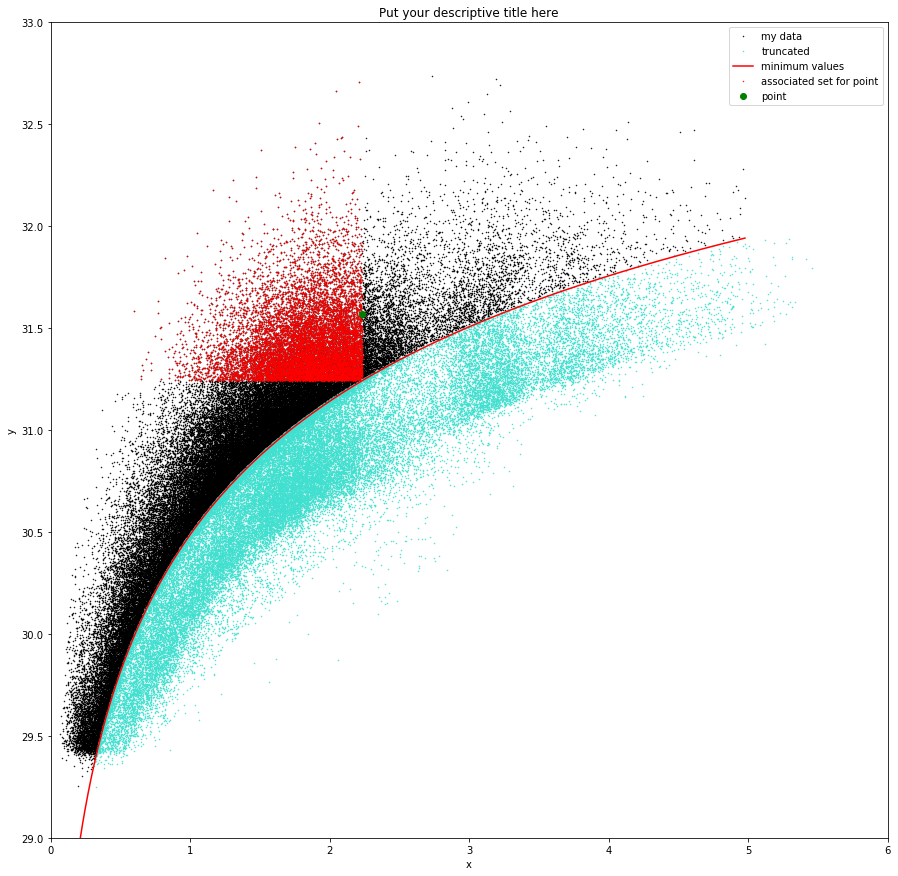

In [76]:
#make sanity checking plots

#L vs z
plt.figure(1, figsize=(15,15))
plt.plot(data[:,0], np.log10(data[:,3]),'.', markersize=1, label="my data", color='black')
plt.plot(data_trunc[:,0], np.log10(data_trunc[:,3]),'.', markersize=1, label="truncated", color='#40E0D0')

z_min = data[:,0][np.argsort(data[:,0])]
L_min = data[:,4][np.argsort(data[:,0])]
plt.plot(z_min, np.log10(L_min),'-', markersize=3, label="minimum values", color='red')

#associated set
plt.plot(Z_ass, np.log10(L_ass),'.', markersize=1, label="associated set for point", color='red')
plt.plot(data[i,0], np.log10(data[i,3]), '.', markersize=12, label="point", color = 'green')

#labeling
plt.xlabel("x")
plt.ylabel("y")
plt.title("Put your descriptive title here")
plt.legend(loc = "upper right")
axes = plt.gca()
axes.set_xlim([0,6])
axes.set_ylim([29,33])


In [71]:
np.argsort(data[:,0])

array([49885, 52835,  2639, ..., 47042,   173, 60261])

In [78]:
#kendall's tau statistic: takes in L'-z coordinates (+Lmin') and calculates correlation. 
def tau(Z, L, Lmin):
    #sum over all elements in dataset
    resid = 0
    var = 0
    for i in range(0, len(Z)):
        #create associated sets
        j = [m for m in range(0, len(Z)) if (L[m] >= Lmin[i] and Z[m] <= Z[i])] #see petrosian
        rankIndex = np.where(np.array(j) == i)
        L_ass = L[j]
        
        #determine rank
        L_rank = stat.rankdata(L_ass) #ranks of all luminosities
        rank = L_rank[rankIndex[0][0]] #determine rank of data point i
        exp = 0.5 * (1 + len(L_ass))
        
        resid = resid + (rank - exp)
        var = var + (1/12.0 * (1 + len(L_ass)**2))
        
        #troubleshooting, also this damn thing runs so slowly holy shit
        if(i % 250 == 0): print i, resid / math.sqrt(var)
        
    t = resid / math.sqrt(var)
    return t
    
tau(data[:,0], data[:,3], data[:,4])

0 1.1331908248109075
250 0.817432057238566
500 1.8304013859151698
750 3.42673247130451
1000 4.923451416594809
1250 5.497003030116404
1500 5.914232570211818
1750 6.617936835523554
2000 6.571870418548724
2250 6.1043650261130304
2500 6.403315198998888
2750 6.262895026972495
3000 6.781768120667969
3250 7.08329546492424
3500 7.713978230720912
3750 7.731815377850151
4000 7.665688345216538
4250 7.968393956203291
4500 7.874106036108143
4750 8.095522418814308
5000 8.066535790113297
5250 8.21229555409068
5500 8.807416461354828
5750 9.382892175091353
6000 9.42158152707506
6250 9.858014690443886
6500 9.835643589785946
6750 9.520678984201782
7000 9.920329202949159
7250 10.020091424743395
7500 10.322140227766727
7750 10.387641543262424
8000 10.4266004067097
8250 10.557667281774485
8500 10.936729403074775
8750 10.881670182272266
9000 10.861705637937542
9250 10.849490737375422
9500 10.957056865557663
9750 11.045349489281044
10000 11.146361481276108
10250 11.079275850898142
10500 11.048535371734921
107

31.011016291474682

In [35]:
r = [5,2,5,1,9,3,3,6,0]
stat.rankdata(r)

array([6.5, 3. , 6.5, 2. , 9. , 4.5, 4.5, 8. , 1. ])

0 1.0576867629894748
250 0.07686915772914565
500 0.543246251857235
750 1.7856884154650872
1000 3.0938613089489544
1250 3.4149963184768946
1500 3.696225941983251
1750 4.301549287609384
2000 4.122280315012755
2250 3.460060985513094
2500 3.631096266204826
2750 3.3890539052816995
3000 3.8023872796575606
3250 4.020281864704389
3500 4.416195835446891
3750 4.25280752378416
4000 4.102747368151623
4250 4.33557896260282
4500 4.224353818850431
4750 4.333547097047553
5000 4.2122661434630375
5250 4.226160900748416
5500 4.752464617383598
5750 5.234646560412965
6000 5.213950762556145
6250 5.535628721156072
6500 5.4245974678282
6750 5.047888660494558
7000 5.4202571142129
7250 5.3651084941508165
7500 5.567861320484467
7750 5.590958457391458
8000 5.5670546081572185
8250 5.584532988677516
8500 5.880961180642558
8750 5.788377454470653
9000 5.677920425915522
9250 5.603216925486793
9500 5.649941128481343
9750 5.628774034029769
10000 5.649177721884528
10250 5.538380996087177
10500 5.47229986960651
10750 5.77

17.625865137307255

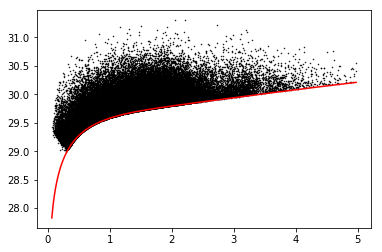

In [83]:
# In[15]: Local Luminosity creation, given k:

#g(z) such that L' = L/g(z). Taken from Singal et al. (2013) and considers high-redshift objects.
def g(z, k):
    z_cr = 3.7
    return (1 + z)**k /(1 + ((1 + z) / z_cr)**k)

def localize(Z, L, Lmin, k):
    L_local = [L[p] / g(Z[p],k) for p in range(0, len(L))]
    Lmin_local = [Lmin[p] / g(Z[p],k) for p in range(0, len(L))]
    return np.array(L_local), np.array(Lmin_local)

#test with k = 3:
k = 3.2
L_local, Lmin_local = localize(data[:,0], data[:,3], data[:,4], k)

#graph of L' vs. z
plt.figure(2)
plt.plot(data[:,0], np.log10(L_local),'.', markersize=1, label="my data", color='black')

Lmin_local_sorted = Lmin_local[np.argsort(data[:,0])] #used to graph the red line
plt.plot(z_min, np.log10(Lmin_local_sorted), markersize=3, label="my data", color='red')


tau(data[:,0], L_local, Lmin_local)

In [64]:
i

0